![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 05. <i>Transformacje geometryczne i cechy obrazów</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższych materiałach zobaczymy jak przy pomocy biblitoeki OpenCV realizować transformacje geometryczne obrazu, wyszukiwać "ciekawe" elementy obrazu oraz jak łączyć je z innymi podobnymi elementami na innych obrazach.

Na początku załadujmy niezbędne biblioteki.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/aitech-wko-pub

Mounted at /content/drive
/content/drive/My Drive/aitech-wko-pub


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Transformacje obrazu

Zacznijmy od podstawowych przekształceń geometrycznych. Aby efekt poszczególnych operacji był widoczny, dodamy pustą przestrzeń wokół testowego obrazu, na którym będziemy pracować:

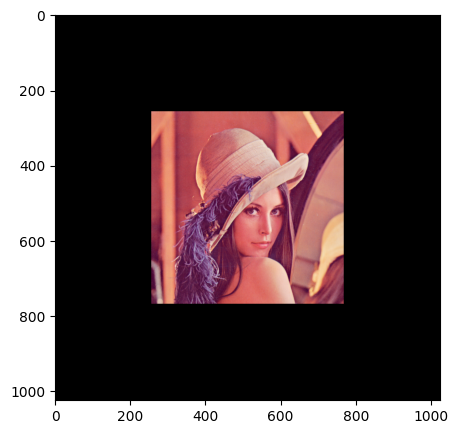

In [ ]:
lena = cv.imread("img/lena.png", cv.IMREAD_COLOR)
image = np.zeros((1024, 1024, 3), np.uint8)

for i in range(3):
    image[256:768, 256:768, i] = lena[:,:, i];

plt.figure(figsize=(5,5))
plt.imshow(image[:,:,::-1]);

W OpenCV [transformacje afiniczne](https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation) są wykonywane przy pomocy definicji macierzy 2x3 (zamiast bardziej klasycznej 3x3), która przekazywana jest do funkcji [`cv.warpAffine()`](https://docs.opencv.org/4.5.3/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983). Poniżej mamy przykład translacji (przesunięcia) o 100 pikseli w prawo wzdłuż osi *x* i o 150 pikseli wzdłuż osi *y*:

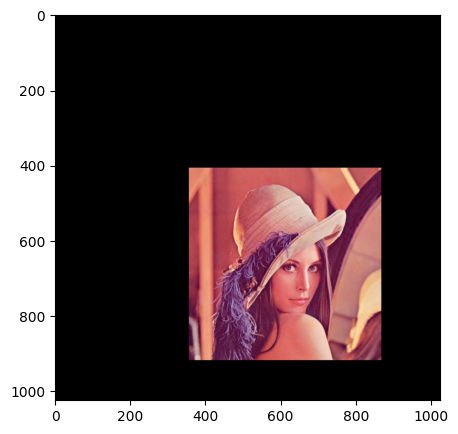

In [ ]:
mat = np.float32([
    [1.0, 0.0, 100],
    [0.0, 1.0, 150]
])

image_translated = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_translated[:,:,::-1]);

Zobaczmy co się stanie po przeskalowaniu dwukrotnym wzdłuż osi *x*:

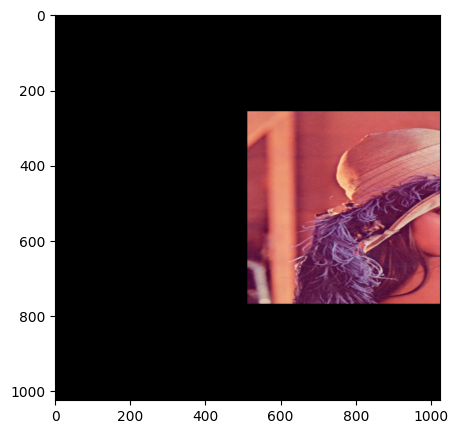

In [ ]:
mat = np.float32([
    [2.0, 0.0, 0],
    [0.0, 1.0, 0]
])

image_scaled = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_scaled[:,:,::-1]);

Nasz wyjściowy obraz "wyszedł" poza wymiary wejściowe, więc musimy podać w funkcji trochę większe rozmiary wynikowego obrazu (w tym wypadku chodzi o szerokość):

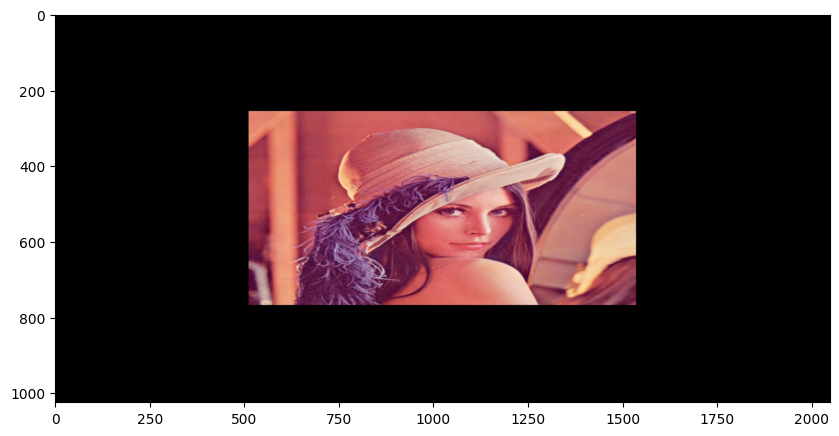

In [ ]:
mat = np.float32([
    [2.0, 0.0, 0],
    [0.0, 1.0, 0]
])

image_scaled = cv.warpAffine(image, mat, (2*image.shape[1], image.shape[0]))

plt.figure(figsize=(10,10))
plt.imshow(image_scaled[:,:,::-1]);

Poniżej mamy dwukrotne przeskalowanie w obu kierunkach (efekt jest zasadniczo widoczny patrząc na wynikowe skale obu osi):

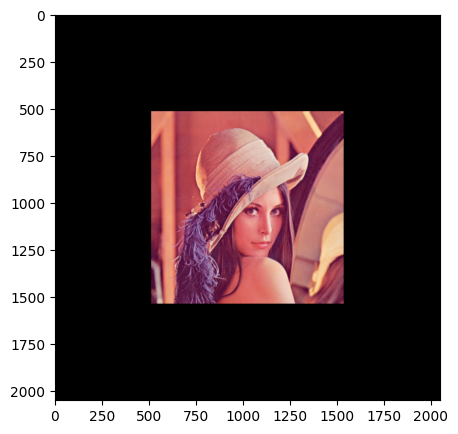

In [ ]:
mat = np.float32([
    [2.0, 0.0, 0],
    [0.0, 2.0, 0]
])

image_scaled = cv.warpAffine(image, mat, (2*image.shape[1], 2*image.shape[0]))

plt.figure(figsize=(5,5))
plt.imshow(image_scaled[:,:,::-1]);

W przypadku obrotu musimy pamiętać, że mamy inaczej zdefiniowany układ współrzędnych (oś *y*), więc uzyskujemy trochę inną formę macierzy obrotu:

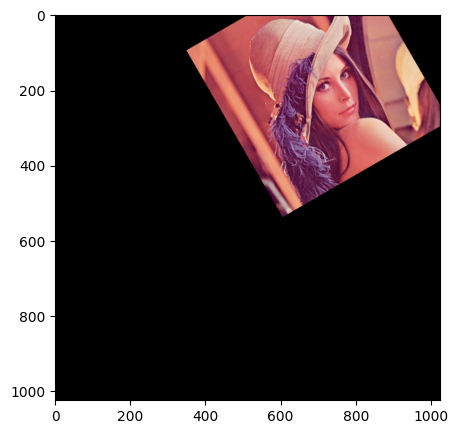

In [ ]:
angle = 30 * np.pi / 180.0

cos_theta = np.cos(angle)
sin_theta = np.sin(angle)

mat = np.float32([
    [ cos_theta, sin_theta, 0],
    [-sin_theta, cos_theta, 0]
])

image_rotated = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_rotated[:,:,::-1]);

Powyżej mieliśmy obrót wokół środka układu, ale możemy też uzyskać obrót wokół wskazanego punktu, np. środka obrazu:

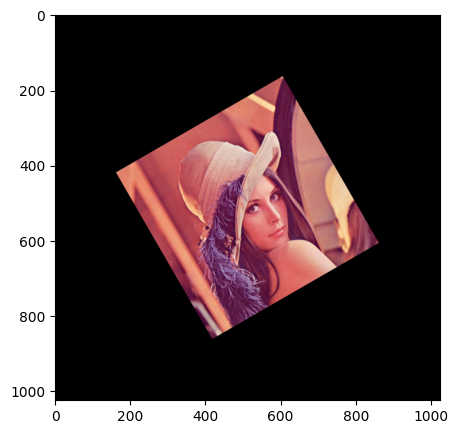

In [ ]:
angle = 30 * np.pi / 180.0

cos_theta = np.cos(angle)
sin_theta = np.sin(angle)

center_x = image.shape[0] / 2
center_y = image.shape[1] / 2

t_x = (1 - cos_theta) * center_x - sin_theta * center_y
t_y = sin_theta * center_x + (1 - cos_theta) * center_y

mat = np.float32([
    [ cos_theta, sin_theta, t_x],
    [-sin_theta, cos_theta, t_y]
])

image_rotated = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_rotated[:,:,::-1]);

Na szczęście zamiast samodzielnego liczenia macierzy obrotu można użyć funkcji [`cv.getRotationMatrix2D()`](https://docs.opencv.org/4.5.3/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326) (możemy też jej użyć do skalowania):

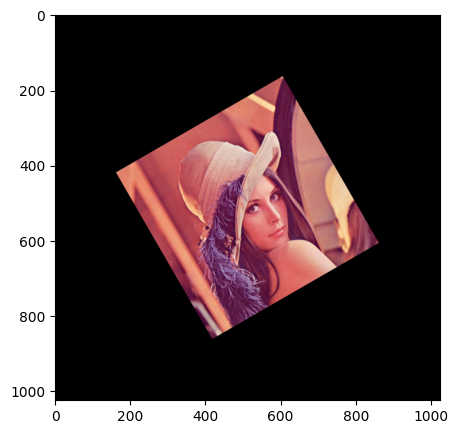

In [ ]:
mat = cv.getRotationMatrix2D((center_x, center_y), 30, 1)

image_rotated = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_rotated[:,:,::-1]);

Poniżej mamy przykład pochylenia:

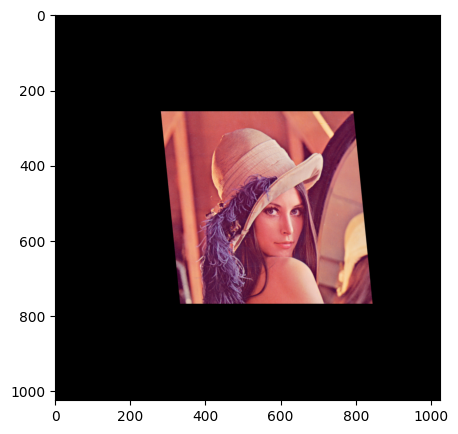

In [ ]:
mat = np.float32([
    [1.0, 0.1, 0],
    [0.0, 1.0, 0]
])

image_sheared = cv.warpAffine(image, mat, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_sheared[:,:,::-1]);

Jeżeli mamy kilka transformacji do wykonania, to bardziej efektywnym rozwiązaniem będzie uprzednie wymnożenie macierzy odpowiedzialnych za poszczególne transformacje (zamiast sukcesywnego wykonywania pojedynczych, izolowanych operacji):

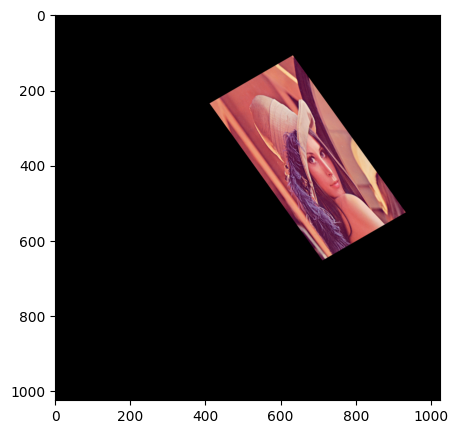

In [ ]:
m_scale = np.float32([
    [0.5, 0.0],
    [0.0, 1.0]
])

m_shear = np.float32([
    [1.0, 0.1],
    [0.0, 1.0]
])

m_rotation = np.float32([
    [ cos_theta, sin_theta],
    [-sin_theta, cos_theta]
])

v_translation = np.float32([
    [150],
    [90]
])

mat_tmp = m_rotation @ m_shear @ m_scale

mat_transformation = np.append(mat_tmp, v_translation, 1)

image_transformed = cv.warpAffine(image, mat_transformation, image.shape[0:2])

plt.figure(figsize=(5,5))
plt.imshow(image_transformed[:,:,::-1]);

Dla punktów o konkretnych współrzędnych możemy też obliczyć ich docelowe współrzędne po transformacjach:

In [ ]:
src_points = np.float32([[50, 50], [50, 249], [249, 50], [249, 249]])
dst_points = (mat_tmp @ src_points.T + v_translation).T

print(dst_points)

[[200.98076 118.30127]
 [317.71466 280.6903 ]
 [287.15027  68.55127]
 [403.88422 230.94032]]


Mając co najmniej 3 punkty wejściowe i ich odpowiedniki wyjściowe, możemy oszacować macierz transformacji przy pomocy funkcji [`cv.estimateAffine2D()`](https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html#ga27865b1d26bac9ce91efaee83e94d4dd):

In [ ]:
mat_estimated_1 = cv.estimateAffine2D(src_points[:3], dst_points[:3])[0]
print("Explicit matrix:\n\n", mat_transformation)
print("\nEstimated matrix:\n\n", mat_estimated_1)

Explicit matrix:

 [[  0.4330127    0.58660257 150.        ]
 [ -0.25         0.8160254   90.        ]]

Estimated matrix:

 [[  0.43301261   0.58660252 150.00000192]
 [ -0.25         0.81602532  90.00000368]]


Mając więcej punktów możemy spróbować uzyskać dokładniejsze oszacowanie:

In [ ]:
mat_estimated_2 = cv.estimateAffine2D(src_points, dst_points)[0]
print("Explicit matrix:\n\n", mat_transformation)
print("\nEstimated matrix:\n\n", mat_estimated_2)

Explicit matrix:

 [[  0.4330127    0.58660257 150.        ]
 [ -0.25         0.8160254   90.        ]]

Estimated matrix:

 [[  0.43301273   0.58660264 149.99997897]
 [ -0.24999996   0.81602536  89.99999603]]


Załóżmy, że chcielibyśmy teraz uzyskać zmianę perspektywy, co w efekcie spowodowałoby, że nasz kwadratowy obraz zamieniłby się w trapez:

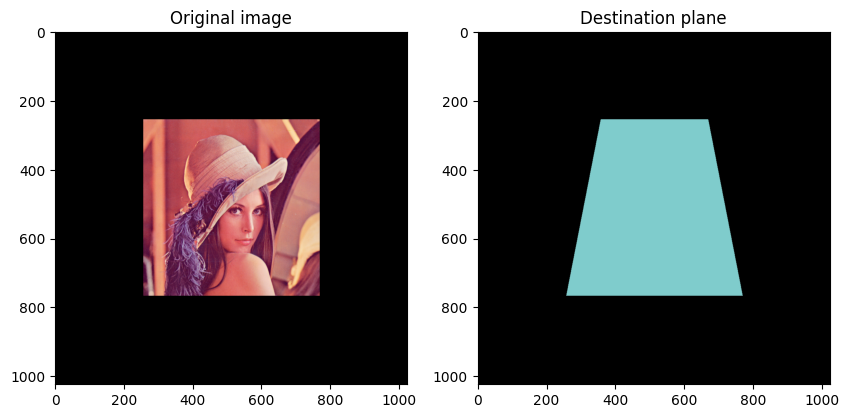

In [ ]:
image_to_transform = np.zeros(image.shape, dtype=np.float32)
dst_points = np.float32([[356, 256], [667, 256], [767, 767], [256, 767]])
cv.fillConvexPoly(image_to_transform, np.int32(dst_points), (0.8, 0.8, 0.5), cv.LINE_AA);

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(image[:,:,::-1])
plt.title('Original image')

plt.subplot(122)
plt.imshow(image_to_transform[:,:,::-1])
plt.title('Destination plane');

Niestety przy pomocy transformacji afinicznych [nie jesteśmy w stanie](https://stackoverflow.com/a/45644845) uzyskać zakładanego efektu:

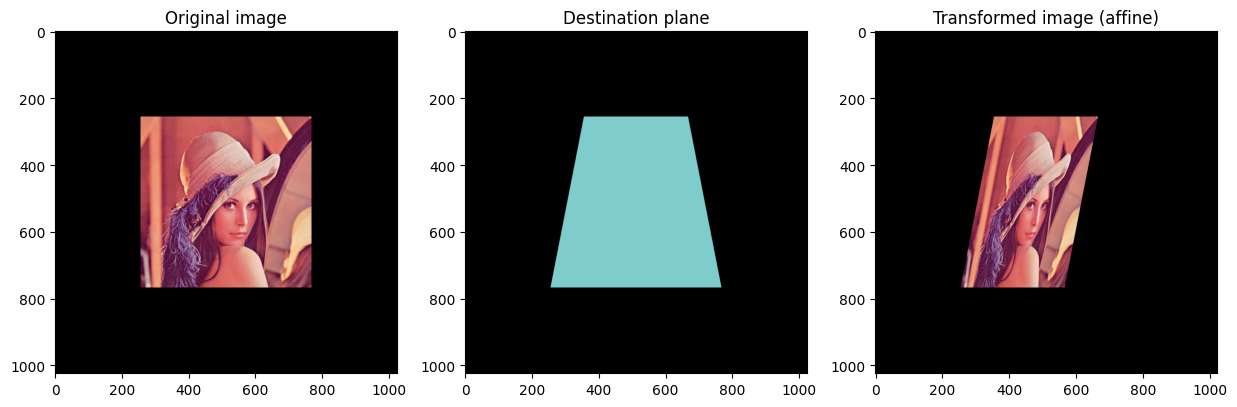

In [ ]:
src_points = np.float32([[256, 256], [767, 256], [767, 767], [256, 767]])
mat_estimated = cv.estimateAffine2D(src_points, dst_points)[0]

image_transformed_a = cv.warpAffine(image, mat_estimated, image.shape[0:2])

plt.figure(figsize=[15,10])
plt.subplot(131)
plt.imshow(image[:,:,::-1])
plt.title('Original image')
plt.subplot(132)
plt.imshow(image_to_transform[:,:,::-1])
plt.title('Destination plane')
plt.subplot(133)
plt.imshow(image_transformed_a[:,:,::-1])
plt.title('Transformed image (affine)');

Do uzyskania zakładanego efektu musimy znaleźć macierz [homografii](https://en.wikipedia.org/wiki/Homography) 3x3 przy pomocy co najmniej 4 punktów i funkcji [`cv.findHomography()`](https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780):

In [ ]:
mat_h = cv.findHomography(src_points, dst_points)[0]
print(mat_h)

[[ 5.08838663e-01 -3.27547619e-01  2.51229024e+02]
 [-2.10957870e-16  3.44904761e-01  1.25737302e+02]
 [-6.74605130e-19 -6.40366802e-04  1.00000000e+00]]


Przy pomocy funkcji [`cv.warpPerspective()`](https://docs.opencv.org/4.5.3/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) możemy dokonać teraz zmiany perspektywy:

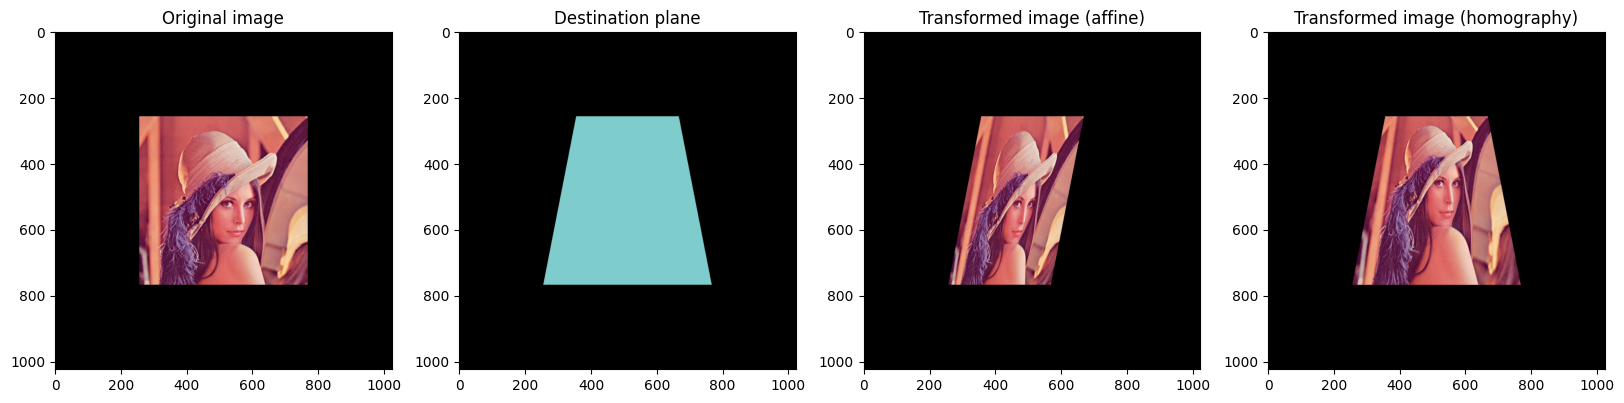

In [ ]:
image_transformed_h = cv.warpPerspective(image, mat_h, image.shape[0:2])

plt.figure(figsize=[20,10])
plt.subplot(141)
plt.imshow(image[:,:,::-1])
plt.title('Original image')
plt.subplot(142)
plt.imshow(image_to_transform[:,:,::-1])
plt.title('Destination plane')
plt.subplot(143)
plt.imshow(image_transformed_a[:,:,::-1])
plt.title('Transformed image (affine)')
plt.subplot(144)
plt.imshow(image_transformed_h[:,:,::-1])
plt.title('Transformed image (homography)');

Poprzez znalezienie macierzy homografii i zmianę perspektywy możemy np. wyrównywać zdjęcia dokumentów w celu ich dalszej analizy. Poniżej mamy przykład z oznaczeniem okładki zeszytu:

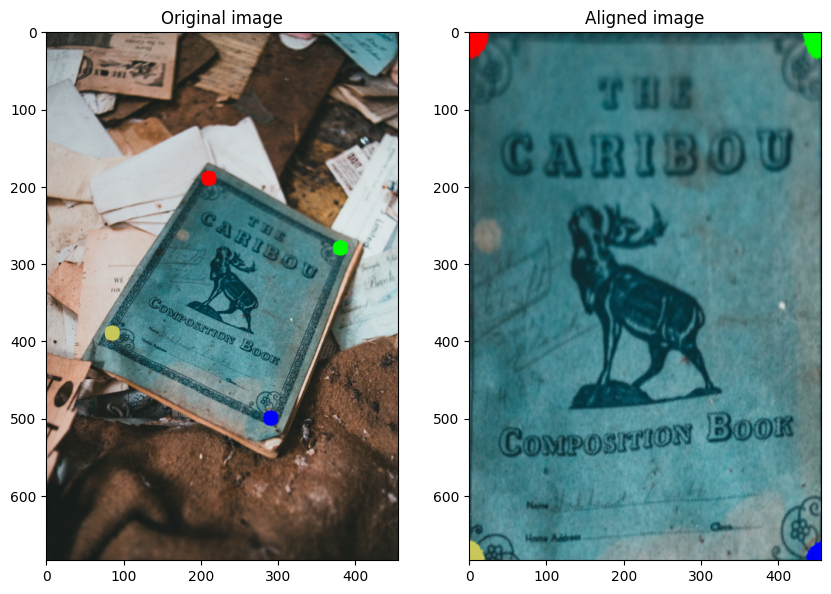

In [ ]:
book = cv.imread("img/caribou.jpg", cv.IMREAD_COLOR)
image_h, image_w = book.shape[0:2]

src_points = np.array([[210, 190], [380, 280], [290, 500], [85, 390]], dtype=float)
dst_points = np.array([[0, 0],[image_w-1, 0], [image_w-1, image_h-1], [0, image_h-1]], dtype=float)

colors = [(0,0,255), (0,255,0), (255,0,0), (90,200,200)]
for (x,y), i in(zip(src_points, colors)):
    book = cv.circle(book, (int(x),int(y)), 10, i, -1)

mat = cv.findHomography(src_points, dst_points)[0]

book_aligned = cv.warpPerspective(book, mat, (image_w, image_h))

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(book[:,:,::-1])
plt.title('Original image')
plt.subplot(122)
plt.imshow(book_aligned[:,:,::-1])
plt.title('Aligned image');

W przypadku dokumentów, możemy np. dysponować wzorem dokumentu do uzupełnienia oraz zdjęciem wypełnionego dokumentu. Po wyrówaniu zdjęcia moglibyśmy łatwiej analizować wypełnione pola:

![Przykładowe wyrówanie dokumentu. Źródło: learnopencv.org](img/document-alignment.png)

Cztery niezbędne punkty moglibyśmy wybierać ręcznie, jednak w przypadku masowego przetwarzania lepszym rozwiązaniem jest automatyczne znalezienie odpowiadających sobie punktów (niekoniecznie rogów dokumentu) na wzorcu i przetwarzanym zdjęciu. Poniżej zobaczymy jak można znaleźć i dopasować takie punkty.

# Punkty kluczowe

Punkty kluczowe (ang. *keypoints*) są punktami na obrazie, o których możemy myśleć w kategoriach dobrze zdefiniowanych narożników, relatywnie odpornych na przekształcenia obrazu. Każdy punkt kluczowy ma przypisany descryptor tj. [wektor cech](https://stackoverflow.com/a/42116946).

Wczytajmy przykładowy obraz, na którym postaramy się znaleźć takie punkty kluczowe:

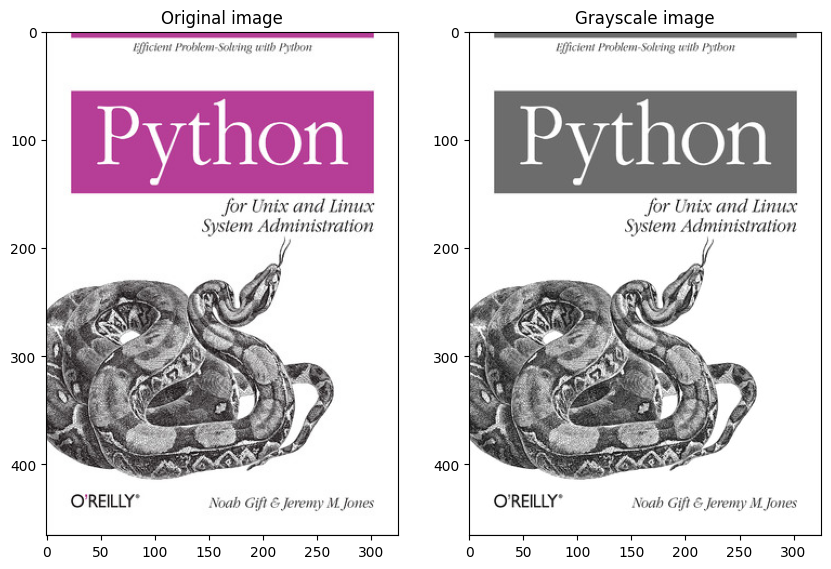

In [ ]:
python_book = cv.imread("img/book-python-cover.jpg", cv.IMREAD_COLOR)
python_book_gray = cv.cvtColor(python_book, cv.COLOR_BGR2GRAY)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(python_book[:,:,::-1])
plt.title('Original image')
plt.subplot(122)
plt.imshow(python_book_gray, cmap='gray')
plt.title('Grayscale image');

Jednym z najpopularniejszych (i nieopatentowanych) algorytmów wykrywania i opisywania punktów kluczowych jest [ORB](https://docs.opencv.org/4.5.3/d1/d89/tutorial_py_orb.html) ([dokumentacja](https://docs.opencv.org/4.5.3/db/d95/classcv_1_1ORB.html)). Poniżej znajduje się wizualizacja wykrytych punktów kluczowych:

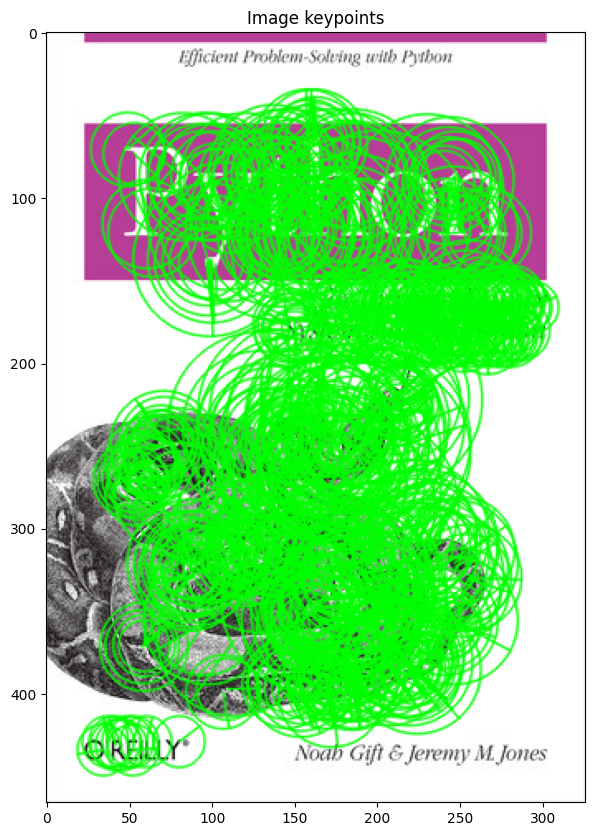

In [ ]:
orb_alg = cv.ORB_create()

keypoints_1 = orb_alg.detect(python_book_gray, None)

keypoints_1, descriptors_1 = orb_alg.compute(python_book_gray, keypoints_1)

python_book_keypoints = cv.drawKeypoints(python_book, keypoints_1, None, color=(0,255,0), 
                                         flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.imshow(python_book_keypoints[:,:,::-1])
plt.title('Image keypoints');

# Łączenie punktów kluczowych

Załóżmy, że chcemy sprawdzić czy na danym zdjęciu znajduje się okładka powyższej książki:

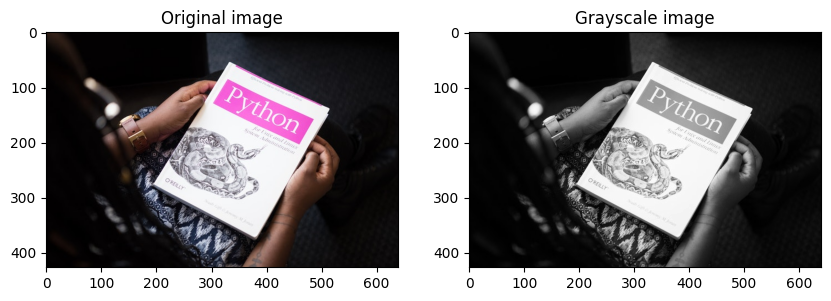

In [ ]:
book_in_hands = cv.imread("img/book-python-in-hands.jpg", cv.IMREAD_COLOR)
book_in_hands_gray = cv.cvtColor(book_in_hands, cv.COLOR_BGR2GRAY)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(book_in_hands[:,:,::-1])
plt.title('Original image')
plt.subplot(122)
plt.imshow(book_in_hands_gray, cmap='gray')
plt.title('Grayscale image');

Na początku znajdźmy i opiszmy punkty kluczowe. Oba kroki możemy wykonać jednocześnie przy pomocy metody `detectAndCompute()`:

In [ ]:
orb_alg = cv.ORB_create(nfeatures=1000)

keypoints_1, descriptors_1 = orb_alg.detectAndCompute(python_book_gray, None)
keypoints_2, descriptors_2 = orb_alg.detectAndCompute(book_in_hands_gray, None)

Jeśli uda nam się połączyć odpowiadające sobie punkty kluczowe i wyliczyć macierz homografii, to z dość dużą dozą pewności będziemy mogli przyjąć, że na zdjęciu znajduje się szukany obiekt i będziemy mogli z grubsza wskazać gdzie on się znajduje. Punkty kluczowe są opisane przez wektory, więc np. moglibyśmy [*brute-forcem* i odległością Hamminga](https://docs.opencv.org/4.5.3/d3/da1/classcv_1_1BFMatcher.html) poszukać najlepszych odpowiedników. W poniższym przypadku pozostawimy 5% najlepszych dopasowań i zwizualizujemy te dopasowania:

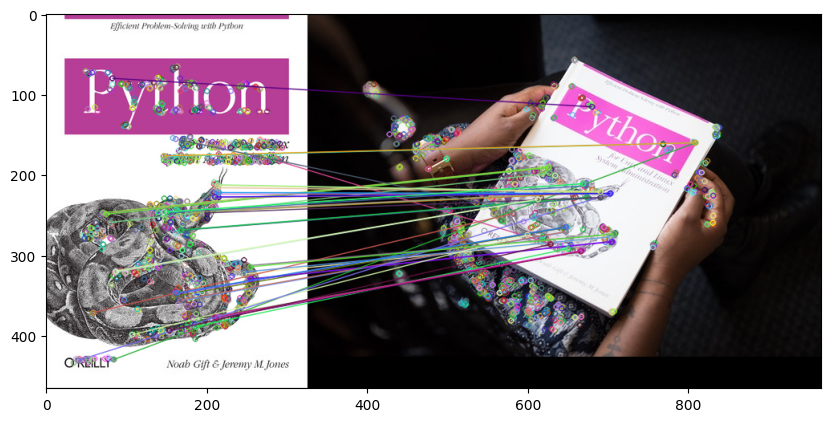

In [ ]:
matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors_1, descriptors_2, None)

matches.sort(key=lambda x: x.distance, reverse=False) # sort by distance

num_good_matches = int(len(matches) * 0.05) # save 5%
matches = matches[:num_good_matches]

image_matched = cv.drawMatches(python_book, keypoints_1, book_in_hands, keypoints_2, matches, None)
plt.figure(figsize=(10,10))
plt.imshow(image_matched[...,::-1]);

Jak widać część punktów jest niepoprawnie dopasowana. Na szczęście obliczenie macierzy homografii odbywa się przy pomocy algorytmu [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) (ang. *random sample consensus*), co pozwala wziąć pod uwagę, że pewne odzwierciedlenia są złe. Aby oznaczyć miejsce występowania obiektu, transformujemy współrzędne narożników źródłowego zdjęcia przy użyciu otrzymanej macierzy i funkcji [`cv.perspectiveTransform()`](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gad327659ac03e5fd6894b90025e6900a7):

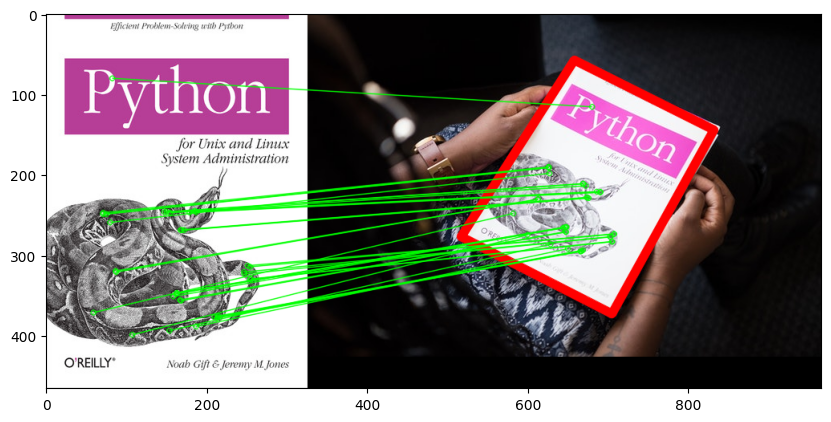

In [ ]:
src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

mat, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matches_mask = mask.ravel().tolist()
height, width, _ = python_book.shape

pts = np.float32([[0,0], [0,height-1], [width-1,height-1], [width-1,0]]).reshape(-1,1,2)

dst = cv.perspectiveTransform(pts, mat)

book_in_hands_poly = cv.polylines(book_in_hands,
                                  [np.int32(dst)], True, (0,0,255), 
                                  10, cv.LINE_AA)
    
draw_params = dict(matchColor=(0,255,0),
                   matchesMask=matches_mask, # draw only inliers
                   flags=2) # NOT_DRAW_SINGLE_POINTS
image_matched = cv.drawMatches(python_book, keypoints_1, 
                               book_in_hands_poly, keypoints_2, 
                               matches, None, **draw_params)

plt.figure(figsize=(10,10))
plt.imshow(image_matched[...,::-1]);

# Zadanie 1

Napisz interaktywną aplikację przy pomocy HighGUI, która pozwoli na obrazie `img/billboards.jpg` wybrać 4 punkty i umieścić w zaznaczonym obszarze wybrany obraz, np. `img/bakery.jpg`.

![Aplikacja](img/app-billboard.png)

In [ ]:
img_b = cv.imread("img/bakery.jpg")
img_b = cv.cvtColor(img_b, cv.COLOR_BGR2RGB)
#plt.imshow(img_b)
img_b = cv.resize(img_b, (224, 126), interpolation = cv.INTER_AREA)
print(img_b.shape)

b = np.zeros((1024, 1024, 3), np.uint8)

for i in range(3):
    b[128:128+126, 128:128+224, i] = img_b[:,:, i];



def make_slid(a_min:int, a_max:int, curr:int, slider_id:str, root_win_name:str, on_change_callback=lambda x: x):
    cv.createTrackbar(slider_id, root_win_name, a_min, a_max, on_change_callback)
    cv.setTrackbarPos(slider_id, root_win_name, curr)
    return slider_id

def getslid(*ids, root_wind:str):
    results = [cv.getTrackbarPos(idd, root_wind) for idd in ids]
    img = cv.imread("img/billboards.jpg")
    #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    for x in range(4):
        img = cv.circle(img, (results[x*2], results[x*2+1]), 10, (255, 0, 0), 3)
    
    return img

def generate_image(*ids, root_wind:str):
    results = [cv.getTrackbarPos(idd, root_wind) for idd in ids]
    src_points = np.float32([[128, 128], [128+224, 128], [128+224, 128+126], [128, 128+126]])
    dst_points = np.float32([[results[0], results[1]], [results[2], results[3]],[results[6], results[7]], [results[4], results[5]]])
    mat_estimated = cv.findHomography(src_points, dst_points)[0]
    image_transformed = cv.warpPerspective(b, mat_estimated, b.shape[0:2])
    image_transformed = cv.cvtColor(image_transformed, cv.COLOR_BGR2RGB)
    _, mask = cv.threshold(image_transformed, 1, 255, cv.THRESH_BINARY)
    center = (int((results[0] + results[6]) / 2), int((results[1] + results[7]) / 2))
    img = cv.imread("img/billboards.jpg")
    image = cv.seamlessClone(image_transformed, img, mask, center, cv.NORMAL_CLONE)
    return image

def setslid(id_:str, value:int, root_wind:str):
    cv.setTrackbarPos(id_, root_wind, value)

window_name = 'Billboard change';
cv.namedWindow(window_name)

sliders = [
    make_slid(0, 895, 100, "left_top_x", window_name),
    make_slid(0, 503, 100, "left_top_y", window_name),
    make_slid(0, 895, 200, "right_top_x", window_name),
    make_slid(0, 503, 100, "right_top_y", window_name),
    make_slid(0, 895, 200, "right_bottom_x", window_name),
    make_slid(0, 503, 200, "right_bottom_y", window_name),
    make_slid(0, 895, 100, "left_bottom_x", window_name),
    make_slid(0, 503, 200, "left_bottom_y", window_name),
]

imagee = cv.imread("img/billboards.jpg")
done = False
while True:
    if not done:
        imagee = getslid("left_top_x", "left_top_y", "right_top_x", "right_top_y", "left_bottom_x", "left_bottom_y",  "right_bottom_x",  "right_bottom_y",root_wind=window_name)
    cv.imshow(window_name, imagee)
    
    code = cv.waitKey(1)

    if code == ord('q'):
        break
    if code == ord('g'):
        imagee = generate_image("left_top_x", "left_top_y", "right_top_x", "right_top_y", "left_bottom_x", "left_bottom_y",  "right_bottom_x",  "right_bottom_y",root_wind=window_name)
        done = True
        plt.imshow(imagee[:,:,::-1])


cv.destroyAllWindows()

(126, 224, 3)


# Zadanie 2

Załóżmy, że mamy dwa zdjęcia, które chcielibyśmy połączyć w panoramę:

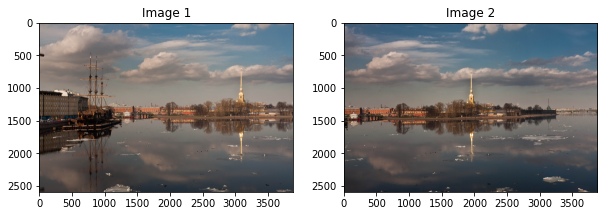

In [5]:
boat_1 = cv.imread("img/boat_1.jpg", cv.IMREAD_COLOR)
boat_2 = cv.imread("img/boat_2.jpg", cv.IMREAD_COLOR)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(boat_1[:,:,::-1])
plt.title('Image 1')
plt.subplot(122)
plt.imshow(boat_2[:,:,::-1])
plt.title('Image 2');

Standardowo w OpenCV panoramę tworzy się przy pomocy klasy [`Stitcher`](https://docs.opencv.org/4.5.3/d2/d8d/classcv_1_1Stitcher.html), której można podać listę zdjęć do połączenia:

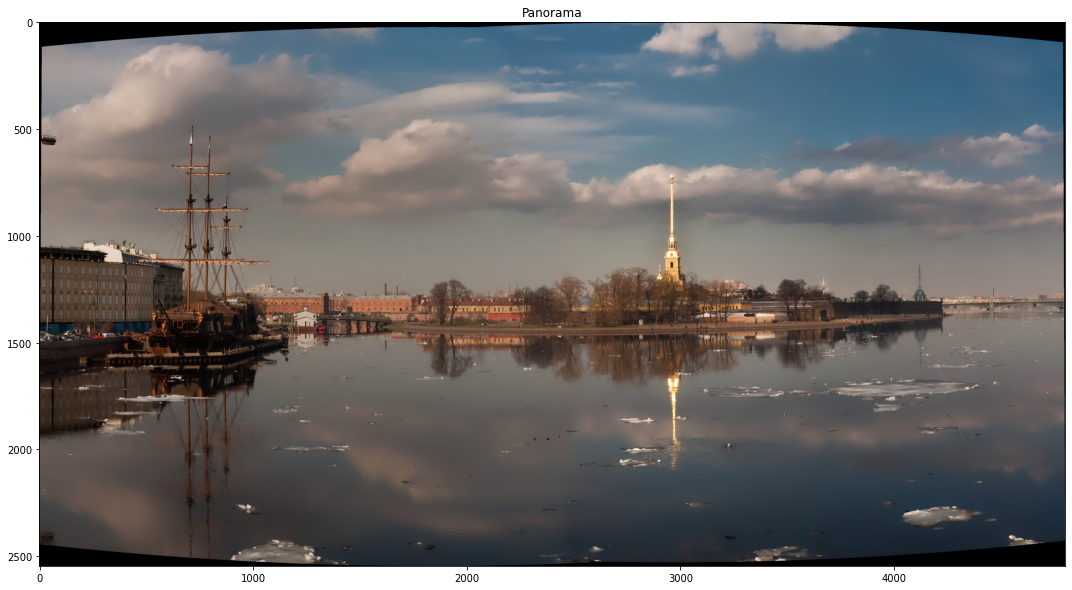

In [6]:
stitcher_alg = cv.Stitcher_create()
_, panorama = stitcher_alg.stitch([boat_1, boat_2])
plt.figure(figsize=[20,10]) 
plt.imshow(panorama[:,:,::-1])
plt.title('Panorama');

Spróbuj zaimplementować samodzielne stworzenie panoramy. Poniższy efekt będzie wystarczający, aczkolwiek możesz również spróbować zniwelować widoczną różnicę w intensywnościach na granicy zdjęć.

![Panorama](img/panorama-manual.png)

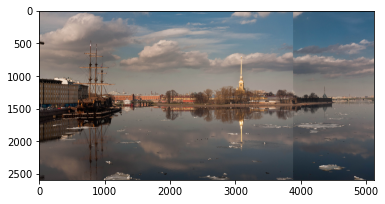

In [4]:
from PIL import Image

def merge_images(file1, file2):
    """Merge two images into one, displayed side by side
    :param file1: path to first image file
    :param file2: path to second image file
    :return: the merged Image object
    """
    image1 = Image.open(file1)
    image2 = Image.open(file2)
 
    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result
boat_2 = cv.imread("img/boat_2.jpg", cv.IMREAD_COLOR)
boat_2 = boat_2[:, 2650:]
cv.imwrite('boat_2.jpg',boat_2)
plt.imshow(merge_images('img/boat_1.jpg','boat_2.jpg'))